<a href="https://colab.research.google.com/github/wheemin-2/24-2-ESAA/blob/main/0916_HW_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instacart Market Basket Analysis**

https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

## **Objective**

to predict which products will be in a user's next order

In [1]:
#import the necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None # default ='warn', 경고창 끄기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from subprocess import check_output
print(check_output(['ls','/content/drive/MyDrive/Colab Notebooks/ESAA/data/Instacart']).decode('utf8'))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [4]:
#파일 불러오기

order_products_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/Instacart/order_products__train.csv')
order_products_prior_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/Instacart/order_products__prior.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/Instacart/orders.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/Instacart/products.csv')
aisles_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/Instacart/aisles.csv')
departments_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/Instacart/departments.csv')

In [5]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


* order_number : 해당 고객의 몇 번째 주문인지를 나타낸 변수

In [6]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


* add_to_cart_order : 해당 주문에서 해당 제품이 몇 번째로 주문되었는지를 나타내는 변수
* reordered : 재구매 여부를 나타내는 변수 (0,1)

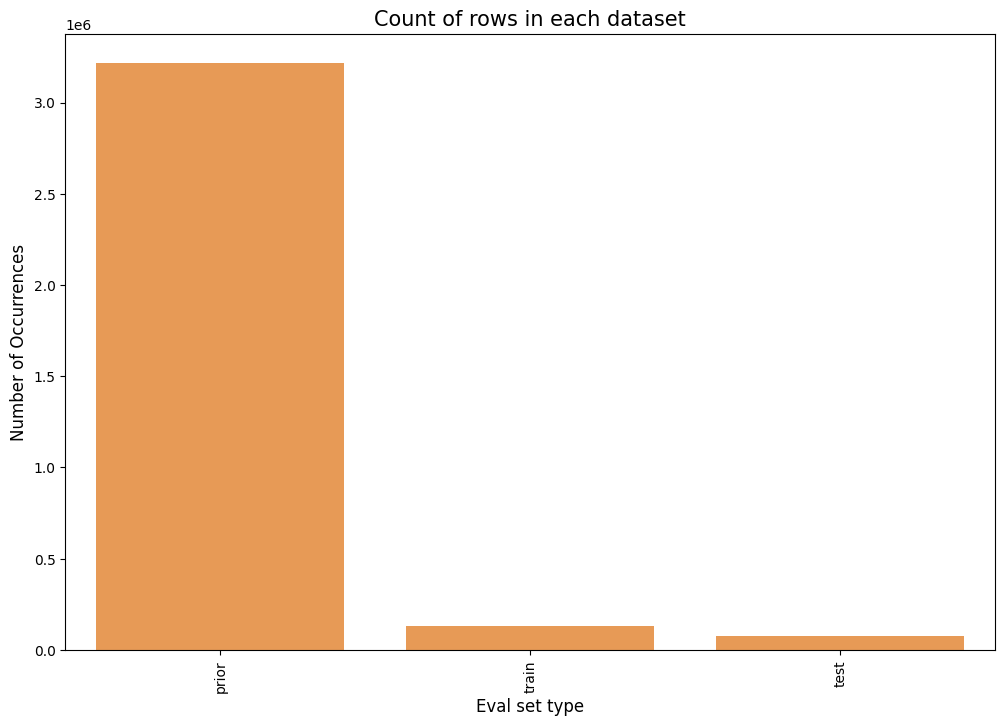

In [8]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [9]:
# 각 eval_set에서 고유한 고객이 몇 명인지 세기 위한 함수
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby('eval_set')['user_id'].aggregate(get_unique_count)
cnt_srs

,user_id
eval_set,
prior,206209
test,75000
train,131209


총 206209명의 고객이 있음
그 중 131209명의 데이터가 train dataset, 75000명의 데이터 test dataset으로 잡아 예측

<ipython-input-10-539368372479>:1: FutureWarning: The provided callable <function max at 0x7e51f33139a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()


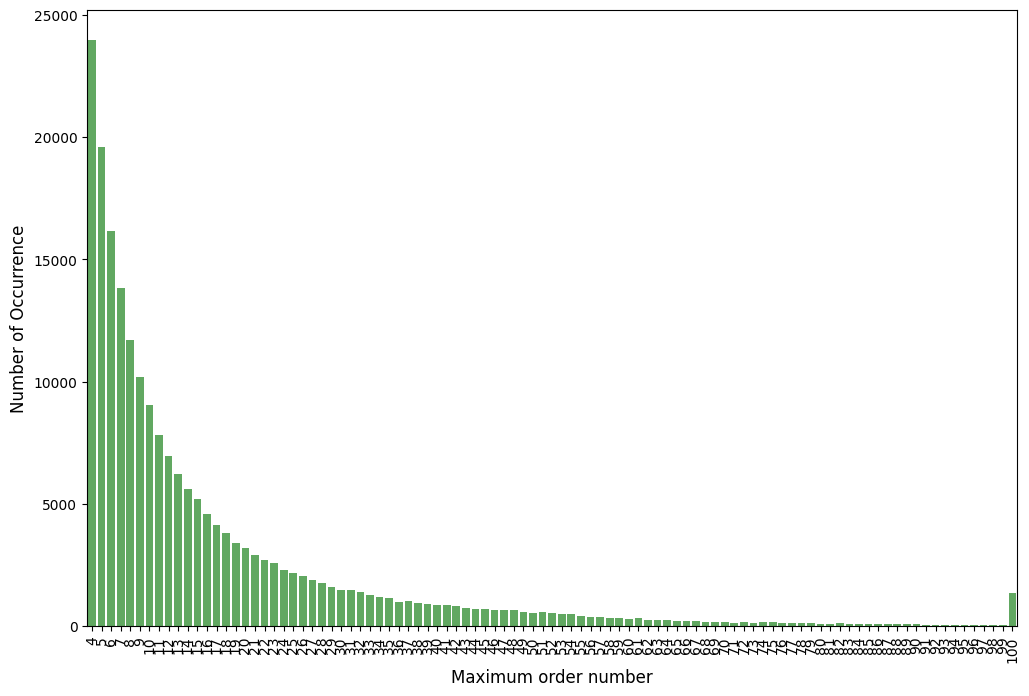

In [10]:
cnt_srs = orders_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrence', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

See how the ordering habit changes with day of week

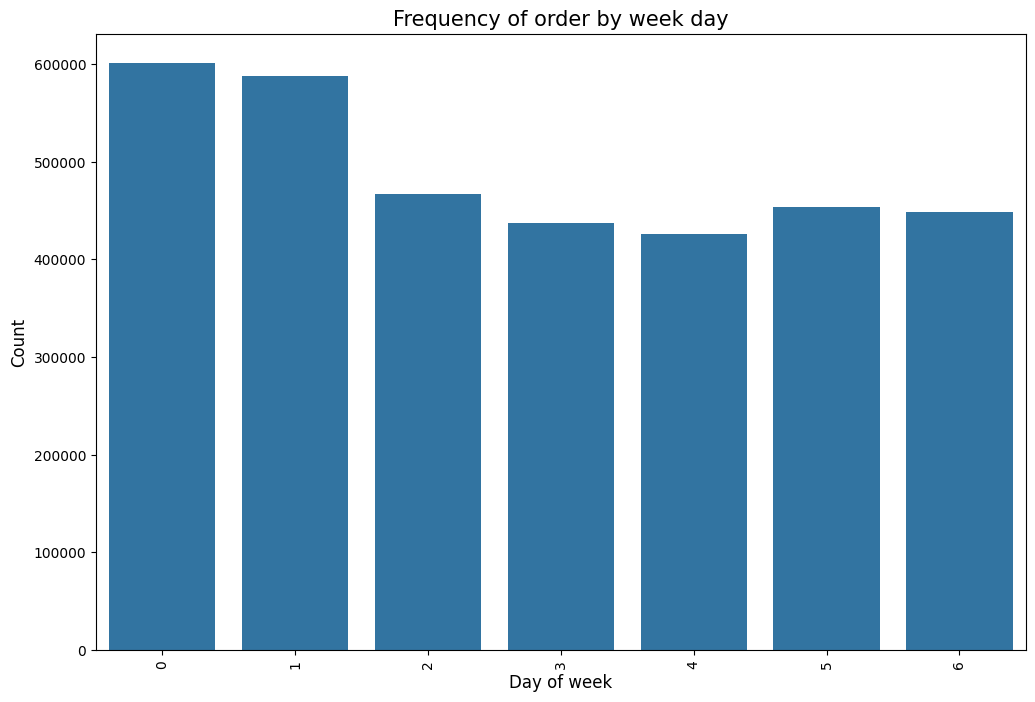

In [11]:
# 요일에 따른 주문량 확인
plt.figure(figsize=(12,8))
sns.countplot(data=orders_df, x='order_dow', color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of order by week day', fontsize=15)
plt.show()

0,1 : Saturday and Sunday > 주문량이 많음
4 : Wednesday > 주문량이 최소

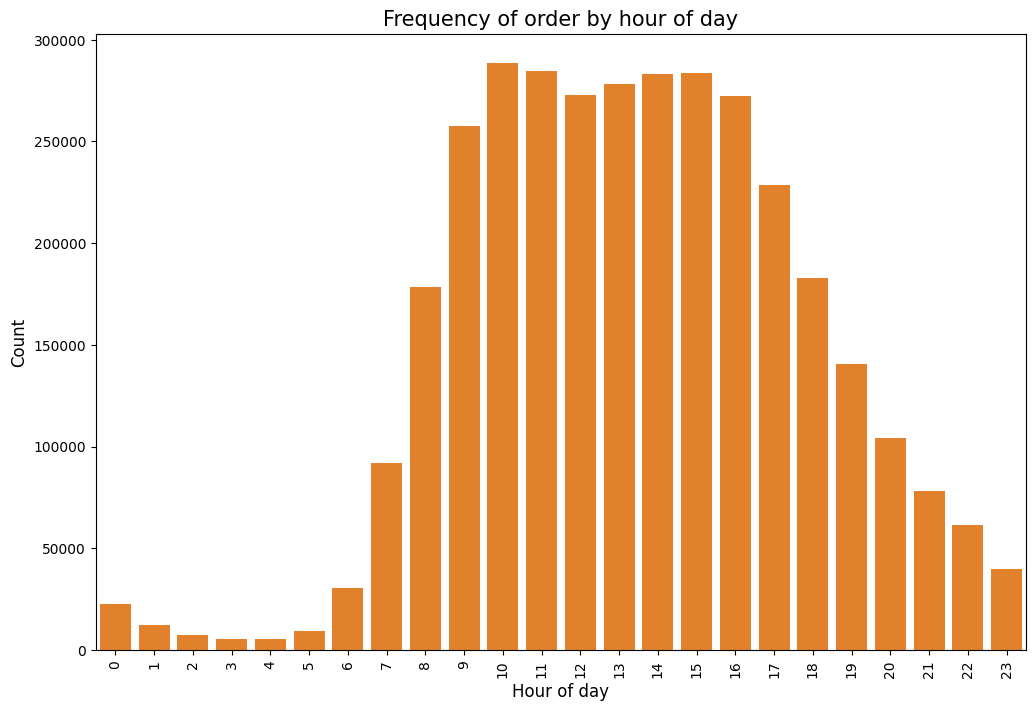

In [12]:
# 시간에 따른 주문량 확인

plt.figure(figsize=(12,8))
sns.countplot(data=orders_df, x='order_hour_of_day', color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title('Frequency of order by hour of day', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

낮 시간에 주문량이 많은 걸 확인할 수 있음

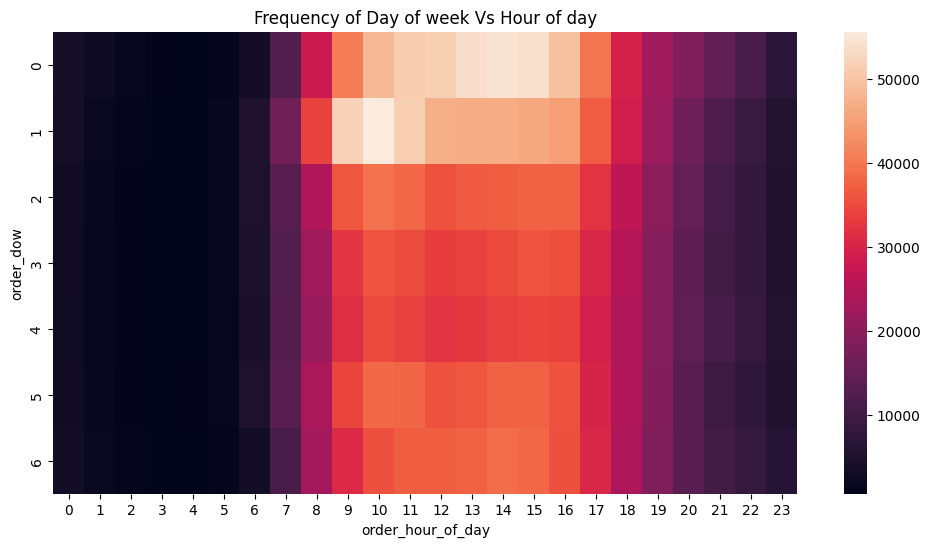

In [13]:
# 요일과 시간에 따른 주문량의 빈도를 확인

grouped_df = orders_df.groupby(['order_dow','order_hour_of_day'])['order_number'].aggregate('count').reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day',values='order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Frequency of Day of week Vs Hour of day')
plt.show()

토요일 오후, 일요일 아침 시간대에 주문이 몰림

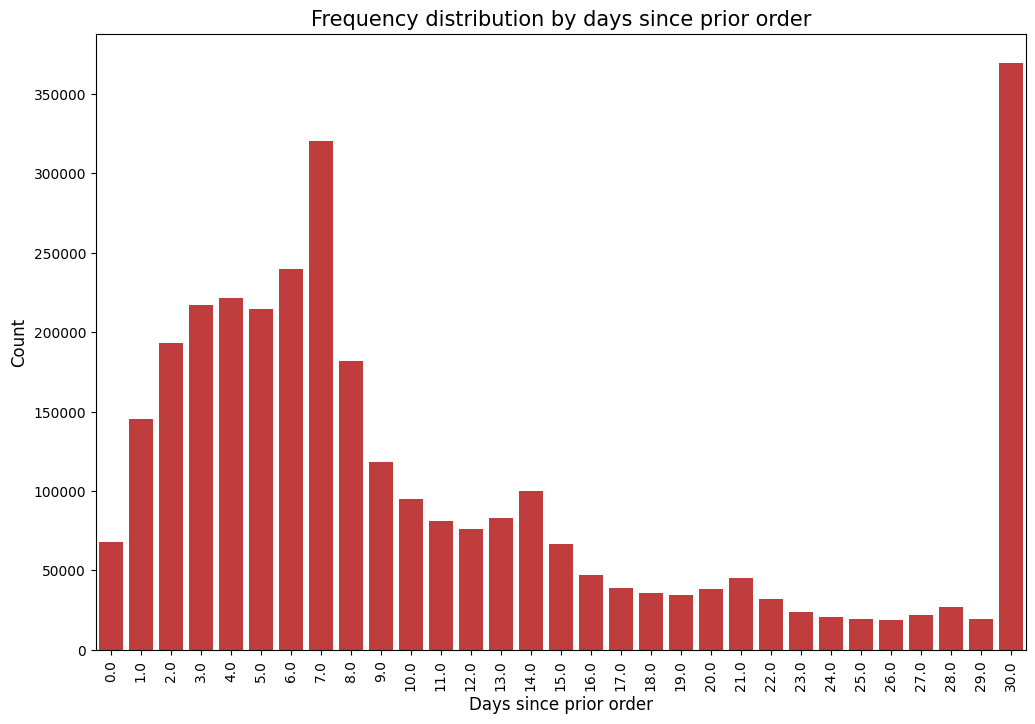

In [14]:
# check time interval between the orders

plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.title('Frequency distribution by days since prior order', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

대체로 일주일에 한 번씩 주문을 하거나 한 달에 한 번씩 주문을 함 (7과 30에서 peak), 또한 7의 배수에서 peak가 있는 것을 볼 수 있음

In [15]:
# check re-order percentage in prior set and train set
# 약 59%의 상품이 리오더 됨
print(order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0])
print(order_products_train_df.reordered.sum() / order_products_train_df.shape[0])


0.5896974667922161
0.5985944127509629


In [16]:
# No re-ordered products

grouped_df = order_products_prior_df.groupby('order_id')['reordered'].aggregate('sum').reset_index()
grouped_df[grouped_df['reordered']>1]=1
grouped_df.reordered.value_counts()/grouped_df.shape[0]

,count
reordered,
1,0.879151
0,0.120849


In [17]:
grouped_df = order_products_train_df.groupby('order_id')['reordered'].aggregate('sum').reset_index()
grouped_df[grouped_df['reordered']>1]=1
grouped_df['reordered'].value_counts()/grouped_df.shape[0]

,count
reordered,
1,0.93444
0,0.06556


prior dataset에서는 약 12% 정도가 reorder 되지 않았고, train dataset에서는 6.5% 정도가 reorder되지 않았음

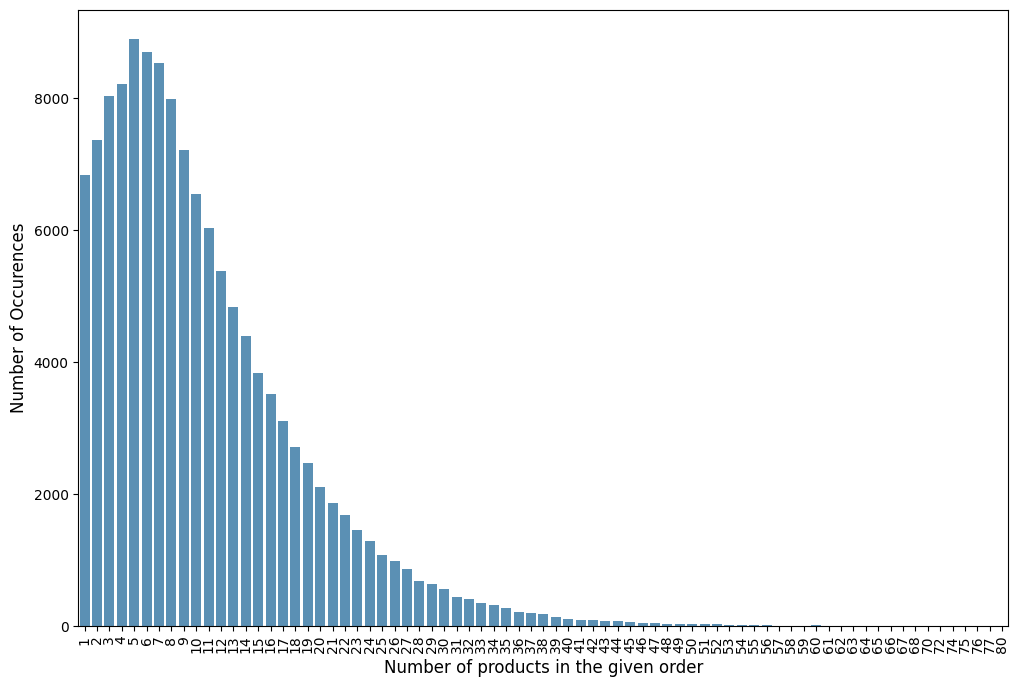

In [18]:
# See the number of products bought in each order
grouped_df = order_products_train_df.groupby('order_id')['add_to_cart_order'].aggregate('max').reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [19]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [21]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
# product detail을 order_prior detail과 merge
# pd.merge(df1,df2,on='',how='') / df1.merge(df2, on='', how='')
order_products_prior_df = order_products_prior_df.merge(products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [23]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


주문량 상위 20위까지는 대부분 농작물/과일

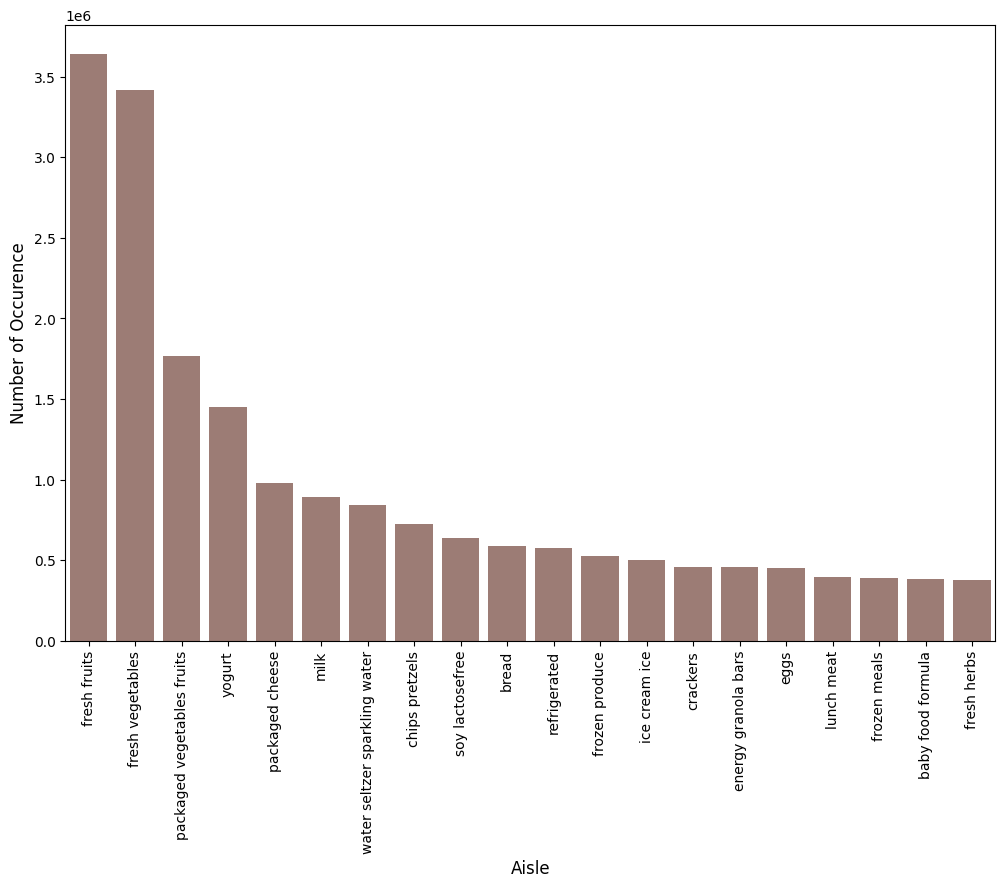

In [24]:
#important aisles

#주문량이 많은 순으로 상위 20개의 aisle을 뽑아 cnt_srs에 저장
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurence', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

상위 2개의 aisle이 fresh fruits와 fresh vegetables임 > 주문량 상위 20개의 product_name을 추출했을 때 확인한 결과와 연결됨

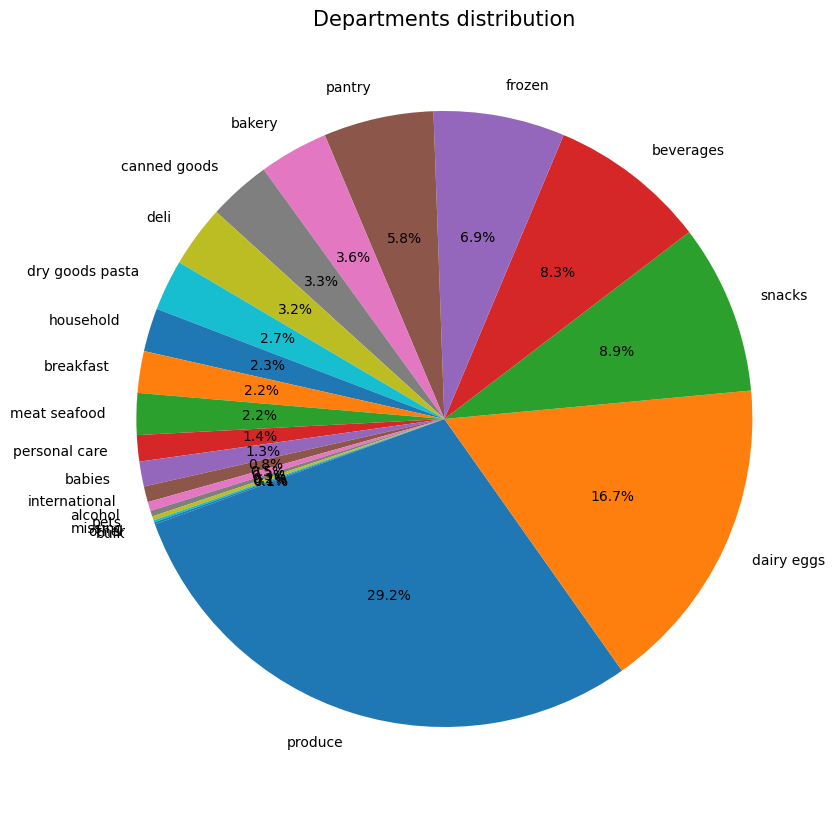

In [25]:
#Department distribution

plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = np.array(temp_series.index)   #uniqe한 dep의 수 : labels
sizes = np.array((temp_series/temp_series.sum())*100)  # 각 dep의 점유율(%)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title('Departments distribution', fontsize=15)
plt.show()

Produce 가 가장 큰 department

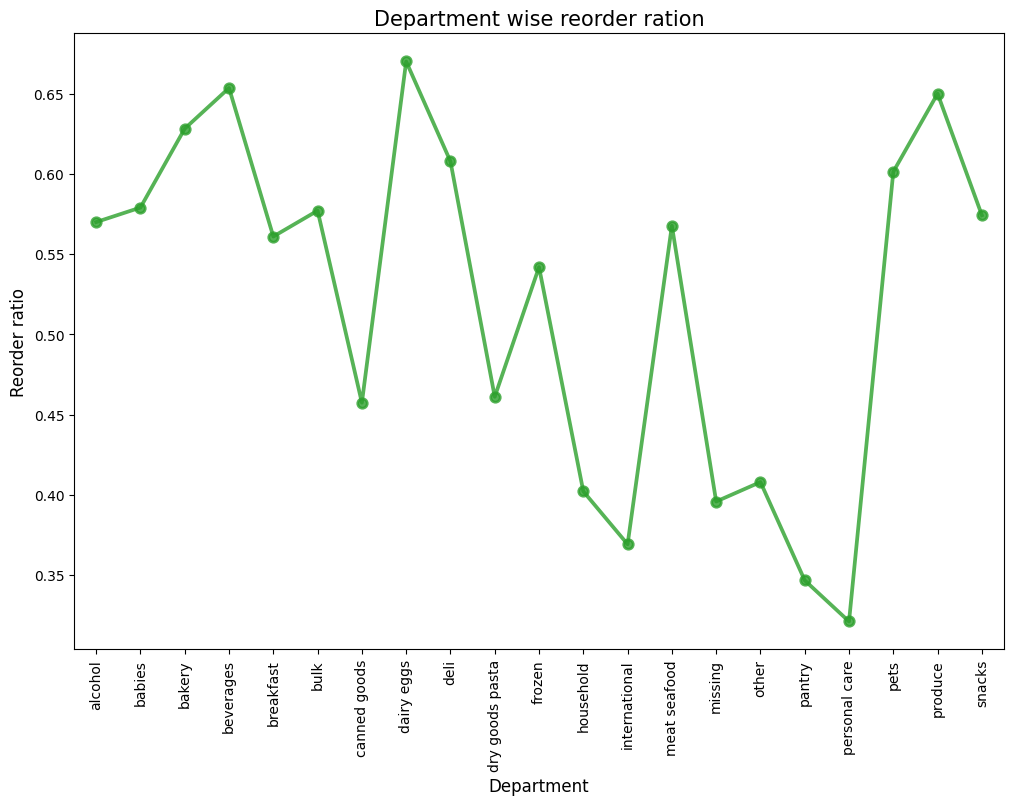

In [26]:
#Check Department wise reorder ratio
#department별로 reorder 비율을 계산해 grouped_df에 저장
grouped_df = order_products_prior_df.groupby(['department'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['department'].values,y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Department wise reorder ration', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Personal care가 가장 낮은 재구매율을, dairy eggs가 가장 높은 재구매율을 보인다

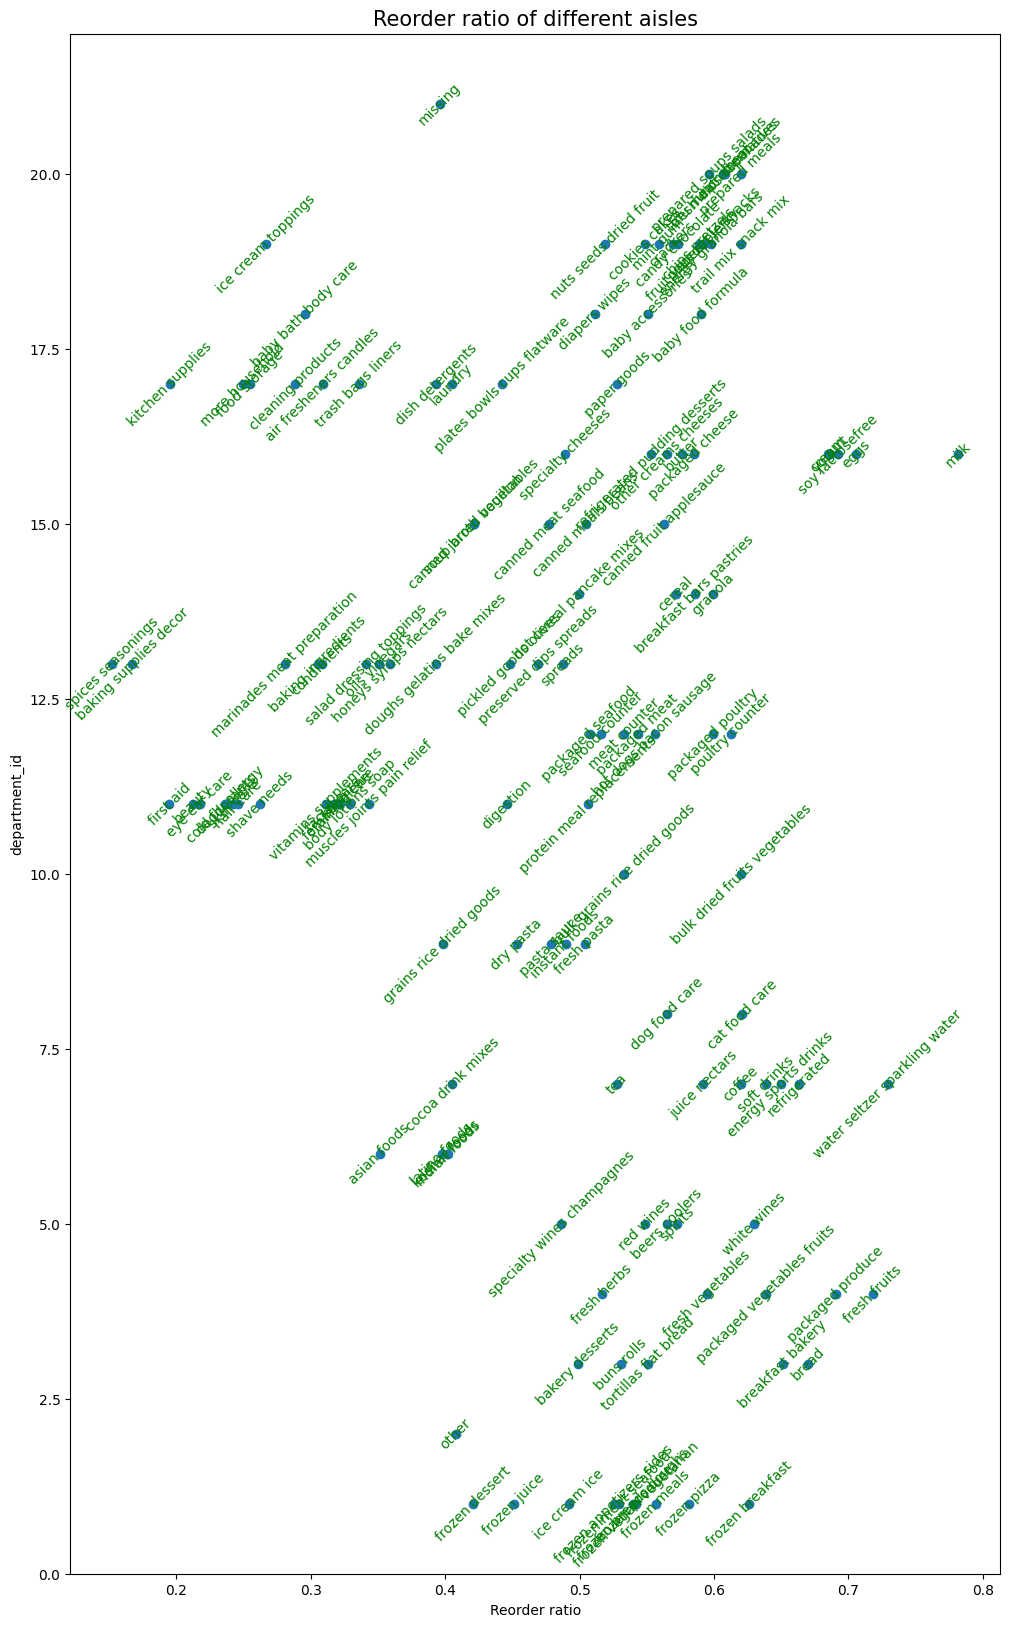

In [27]:
#Aisle wise reorder ratio

grouped_df = order_products_prior_df.groupby(['department_id','aisle'])['reordered'].aggregate('mean').reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, y=grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder ratio'); plt.ylabel('department_id')
plt.title('Reorder ratio of different aisles', fontsize=15)
plt.show()

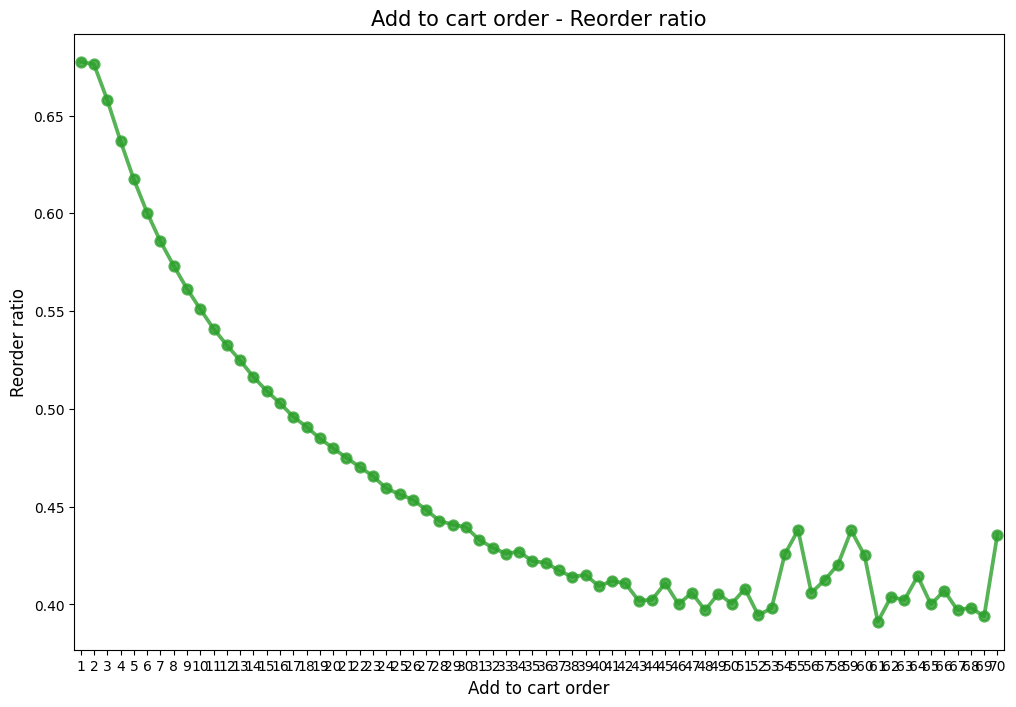

In [28]:
#Add to Cart - reorder ratio
#장바구니에 담는 것과 재구매율의 관계 확인

order_products_prior_df['add_to_cart_order_mod'] = order_products_prior_df['add_to_cart_order'].copy()
order_products_prior_df

order_products_prior_df.loc[order_products_prior_df['add_to_cart_order_mod']>70,'add_to_cart_order_mod']=70
grouped_df = order_products_prior_df.groupby(['add_to_cart_order_mod'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['add_to_cart_order_mod'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title('Add to cart order - Reorder ratio', fontsize=15)
plt.show()

장바구니에 먼저 담겨진 것이 재구매될 확률이 높다

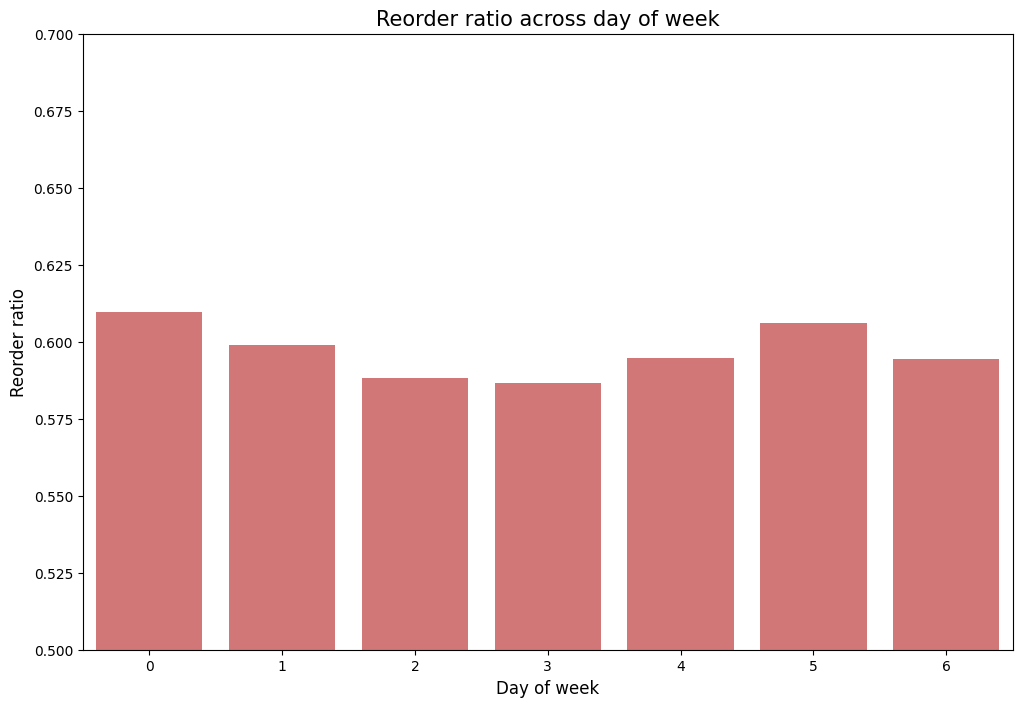

In [29]:
# Reorder ratio by Time based variables
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby('order_dow')['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_dow'].values, y=grouped_df['reordered'].values, color=color[3],alpha=0.7)
plt.ylabel('Reorder ratio', fontsize=12); plt.xlabel('Day of week', fontsize=12)
plt.title('Reorder ratio across day of week', fontsize=15)
plt.ylim(0.5,0.7)
plt.show()

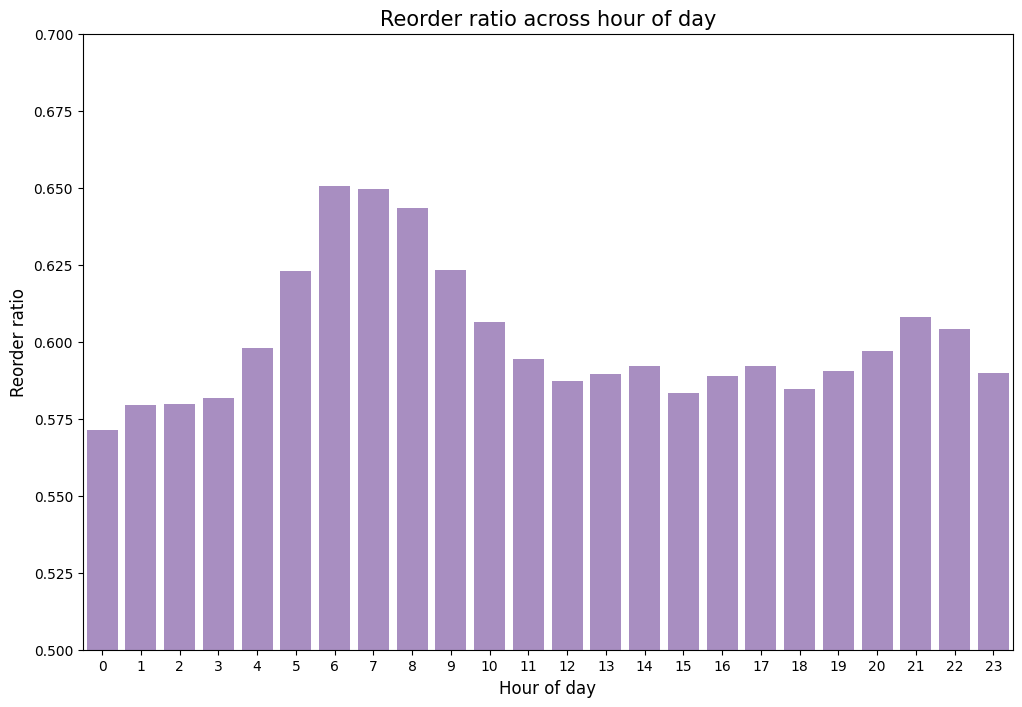

In [30]:
grouped_df = order_products_train_df.groupby(['order_hour_of_day'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_hour_of_day'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.xlabel('Hour of day', fontsize=12); plt.ylabel('Reorder ratio', fontsize=12)
plt.title('Reorder ratio across hour of day', fontsize=15)
plt.ylim(0.5,0.7)
plt.show()

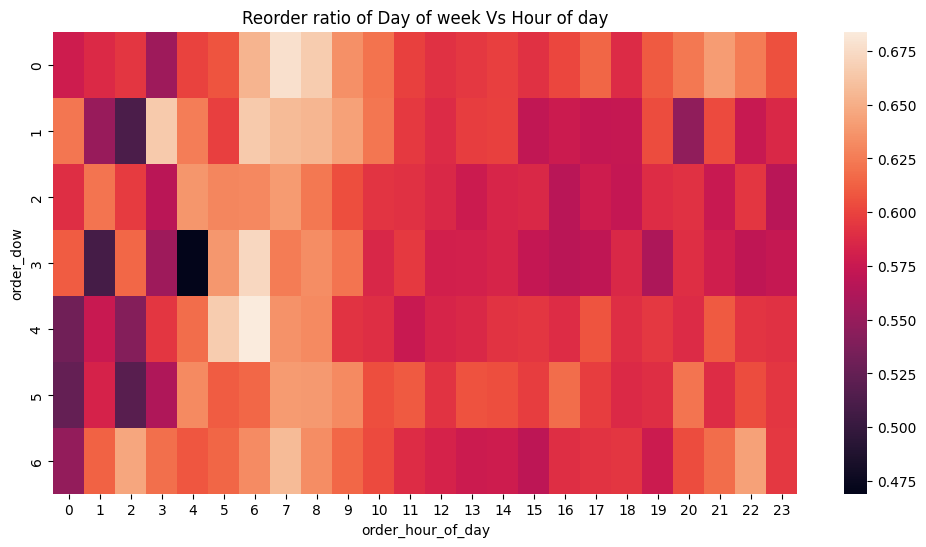

In [31]:
grouped_df = order_products_train_df.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
grouped_df = grouped_df.pivot(index = 'order_dow', columns = 'order_hour_of_day', values = 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Reorder ratio of Day of week Vs Hour of day')
plt.show()

## **그 외의 시각화**

오전에 주로 팔리는 제품과 오후에 주로 팔리는 제품을 비교

In [7]:
orders_df.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [12]:
# orders_df, order_products_prior_df, products_df를 merge
# 최종적으로는 주문한 시간, product_id, product_name이 필요

temp_orders = orders_df[['order_id', 'order_hour_of_day']]
temp_products_prior = order_products_prior_df[['order_id','product_name']]
order_products_time_df = pd.merge(temp_orders, temp_products_prior, on='order_id', how='left')
order_products_time_df.head(10)

,order_id,order_hour_of_day,product_name
0,2539329,8,Soda
1,2539329,8,Organic Unsweetened Vanilla Almond Milk
2,2539329,8,Original Beef Jerky
3,2539329,8,Aged White Cheddar Popcorn
4,2539329,8,XL Pick-A-Size Paper Towel Rolls
5,2398795,7,Soda
6,2398795,7,Pistachios
7,2398795,7,Original Beef Jerky
8,2398795,7,Bag of Organic Bananas
9,2398795,7,Aged White Cheddar Popcorn


In [24]:
# 오전은 6시~12시, 오후는 12시~18시로 설정하여 시간에 따라 df 분리
morning_orders = order_products_time_df[(order_products_time_df['order_hour_of_day']>=6) & (order_products_time_df['order_hour_of_day']<12)]
afternoon_orders = order_products_time_df[(order_products_time_df['order_hour_of_day']>=12) & (order_products_time_df['order_hour_of_day']<=18)]

# 오전, 오후에 많이 팔리는 상위 20개 품목을 추출, 저장
product_morning = morning_orders.product_name.value_counts().head(20)
product_afternoon = afternoon_orders.product_name.value_counts().head(20)

In [25]:
product_morning

,count
product_name,
Banana,163891
Bag of Organic Bananas,130488
Organic Strawberries,89015
Organic Baby Spinach,79550
Organic Hass Avocado,70312
Organic Avocado,57311
Large Lemon,50905
Strawberries,49982
Organic Whole Milk,48124


In [26]:
product_afternoon

,count
product_name,
Banana,241752
Bag of Organic Bananas,193308
Organic Strawberries,135101
Organic Baby Spinach,126201
Organic Hass Avocado,112160
Organic Avocado,94224
Large Lemon,81286
Limes,75816
Strawberries,72265


오전(6시-12시)과 오후(12시-18시)에 많이 판매되는 상품의 구성에는 별다른 차이가 없다



---



## **피벗변환(pivot)**



```
DataFrame.pivot(index=None, columns=None, values=None)
```



* 데이터의 열을 기준으로 피벗테이블로 변환시키는 메서드
* index : 인덱스로 사용될 열을 지정
* columns : 열로 사용될 열을 지정
* values : 값으로 입력될 열을 지정
* DataFrame을 Heatmap을 그리기에 적합한 형태로 변형하는 데에 자주 사용됨

## **파이 차트(Piechart)**



```
temp_series = order_products_prior_df['department'].value_counts()
labels = np.array(temp_series.index)   #uniqe한 dep의 수 : labels
sizes = np.array((temp_series/temp_series.sum())*100)  # 각 dep의 점유율(%)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
```




```
plt.pie(x, labels=None, autopct=None, startangle=0)
```

* x : 1D array-like, the wedge sizes
* labels : list, a seq providing the labels for each wedge
* autopct : 퍼센트를 파이차트 안에 표시
    * '%.1f' : 소수 첫째 자리까지
    * '%.2f' : 소수 둘째 자리까지
    * '%1.1f%%' : 퍼센트까지 포함

* startangle : default=0, 시계방향으로 시작하는 각도를 돌릴 수 있음



## **조건에 따른 DataFrame 값 대체하기 - loc[  ]**



```
#용법
df.loc[조건, 칼럼명] = 대체할 값

#예시
#'part' 컬럼 값이 a일 때 'team' 컬럼 값을 A로 변경
df.loc[df['part']=='a','team'] = 'A'
```



## **ax.annotate()**



```
axes.annotate(text, xy)
```
* 주석을 텍스트로 표기할 때 사용
* text : 주석으로 쓸 텍스트를 입력
* xy : (float, float), 좌표를 입력
* ha : horizontal alignment(가로축 정렬)
    * left, center, right : 점을 기준으로 왼쪽/중앙/오른쪽에 오게 할 건지 결정
* va : vertical alignmnet(세로축 정렬)
    * top, center, botteom
* 점과 함께 텍스트를 표기하고 싶다면 axes.scatter/point 후에 annotate을 하면 됨

